**Abstract:**
The project focuses on the development of a real-time mask detection system using deep learning techniques, specifically the implementation of the AlexNet architecture. The model is trained to classify individuals into three categories: wearing a mask, not wearing a mask, or wearing an improper mask. The trained model is then integrated into a webcam-based application for live mask detection.

**Introduction:**
The ongoing global health crisis has highlighted the importance of preventive measures, including the use of masks, to curb the spread of infectious diseases. Automated mask detection systems can play a crucial role in enforcing safety protocols in various settings, such as public spaces, workplaces, and transportation hubs.

This project leverages the AlexNet architecture, a well-known convolutional neural network (CNN), to develop an accurate and efficient mask detection model. The AlexNet model has proven effective in image classification tasks and is adapted here for the specific task of identifying mask-wearing behavior. The system aims to contribute to public health and safety by providing a reliable tool for monitoring and ensuring compliance with mask-wearing guidelines.


In [ ]:
import os
import cv2
import pickle
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


np.random.seed(1000)
# ignore information messgaes from tensorflow, but we will receieve error messages
os.environ['TFF_CPP_MIN_LOG_LEVEL'] = '2'

%matplotlib inline

c:\Users\Rahiq\.conda\envs\myenv\lib\site-packages\h5py\__init__.py:36: UserWarning: h5py is running against HDF5 1.12.2 when it was built against 1.12.1, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "


In [ ]:
gpu_device = tf.config.experimental.list_physical_devices('GPU')
print(f"Number of GPU = {len(gpu_device)}")
tf.config.experimental.set_memory_growth(gpu_device[0], True)

Number of GPU = 1


**Loading preprocessed datasets** from previously saved pickle files. The X_train, Y_train, X_valid, Y_valid, X_test, and Y_test arrays are individually loaded using the pickle.load function from their respective pickle files. The shapes of the loaded arrays are then printed to verify the successful loading of data. This process ensures the efficient retrieval of preprocessed datasets, allowing for seamless integration into subsequent stages of the machine learning pipeline, such as model training or evaluation, without the need to reprocess the raw images and labels.

In [ ]:
pickle_in = open("./resources/X_train.pickle","rb")
X_train = pickle.load(pickle_in)

pickle_in = open("./resources/Y_train.pickle","rb")
Y_train = pickle.load(pickle_in)

pickle_in = open("./resources/X_valid.pickle","rb")
X_valid = pickle.load(pickle_in)

pickle_in = open("./resources/Y_valid.pickle","rb")
Y_valid = pickle.load(pickle_in)

pickle_in = open("./resources/X_test.pickle","rb")
X_test = pickle.load(pickle_in)

pickle_in = open("./resources/Y_test.pickle","rb")
Y_test = pickle.load(pickle_in)

print(f"X_train= {X_train.shape} Y_train= {Y_train.shape}")
print(f"X_valid= {X_valid.shape} Y_valid= {Y_valid.shape}")
print(f"X_test= {X_test.shape} Y_test= {Y_test.shape}")

X_train= (1662, 227, 227, 3) Y_train= (1662,)
X_valid= (207, 227, 227, 3) Y_valid= (207,)
X_test= (210, 227, 227, 3) Y_test= (210,)


**This code calculates the mean image** (mean_img) from the training dataset (X_train). The mean is computed along the axis 0, which corresponds to the mean pixel values across all images.

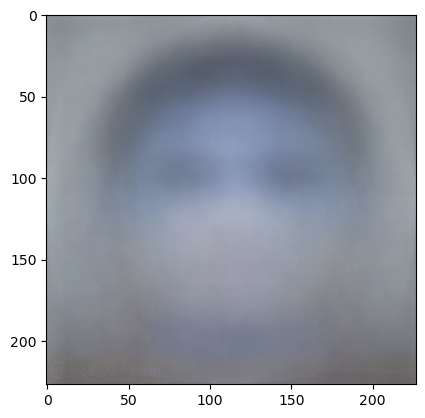

In [ ]:
mean_img = np.mean(X_train, axis=0)
plt.imshow(mean_img.astype('uint8'))

**This code normalizes** the image data by subtracting the previously computed mean image (mean_img) from the training, validation, and test datasets (X_train, X_valid, X_test). The resulting normalized datasets are assigned to X_train_norm, X_valid_norm, and X_test_norm. The code then creates a visual comparison between the original and normalized images for the first five samples in the training set.

In [ ]:
X_train_norm, X_valid_norm, X_test_norm = X_train-mean_img, X_valid-mean_img, X_test-mean_img

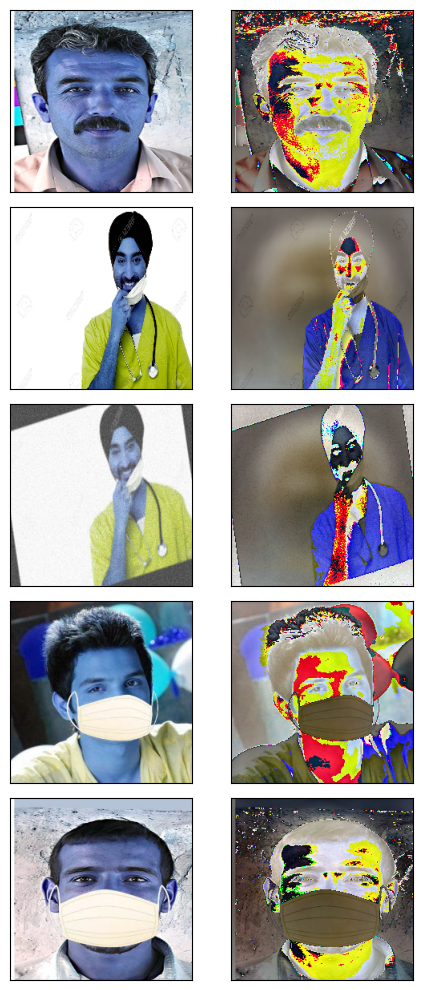

In [ ]:
c = 0
plt.figure(figsize=(5,10))
for i in range(5):
    plt.subplot(5,2,c+1)
    plt.imshow(X_train[i].astype('uint8'))
    plt.xticks([])
    plt.yticks([])

    plt.subplot(5,2,c+2)
    plt.imshow(X_train_norm[i].astype('uint8'))
    plt.xticks([])
    plt.yticks([])

    c += 2

plt.tight_layout()
plt.show()

**This code defines a convolutional **neural network (CNN) model using the Keras library with the specified architecture known as AlexNet. The model consists of multiple convolutional layers with varying filter sizes, activation functions, and batch normalization. It also includes max-pooling layers for spatial down-sampling, dense layers with rectified linear unit (ReLU) activation functions, dropout for regularization, and batch normalization for normalization. The final output layer employs the softmax activation function for multiclass classification, specifically classifying images into three categories (Mask, No Mask, Improper Mask). The model's architecture and parameters are summarized using the model.summary() function, providing a concise overview of the network's layers, shapes, and parameters.

In [ ]:
model = keras.Sequential([
    ## input layer
    keras.Input(shape=X_train.shape[1:]),


    layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), padding='valid'),
    layers.Activation('relu'),
    layers.MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'),
    layers.BatchNormalization(),

    layers.Conv2D(filters=256, kernel_size=(11,11), strides=(1,1), padding='valid'),
    layers.Activation('relu'),
    layers.MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'),
    layers.BatchNormalization(),

    layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='valid'),
    layers.Activation('relu'),
    layers.BatchNormalization(),

    layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='valid'),
    layers.Activation('relu'),
    layers.BatchNormalization(),

    layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='valid'),
    layers.Activation('relu'),
    layers.MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'),
    layers.BatchNormalization(),

    layers.Flatten(),

    layers.Dense(units=4096),
    layers.Activation('relu'),
    layers.Dropout(0.5),
    layers.BatchNormalization(),

    layers.Dense(units=4096),
    layers.Activation('relu'),
    layers.Dropout(0.5),
    layers.BatchNormalization(),

    layers.Dense(3),
    layers.Activation('softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 55, 55, 96)        34944     
                                                                 
 activation (Activation)     (None, 55, 55, 96)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 27, 27, 96)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 27, 27, 96)       384       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 17, 17, 256)       2973952   
                                                                 
 activation_1 (Activation)   (None, 17, 17, 256)       0

**This code compiles** and trains the previously defined AlexNet-inspired convolutional neural network (CNN) model using Keras. The model.compile function configures the training process, specifying the Adam optimizer, sparse categorical cross-entropy as the loss function (suitable for integer-encoded class labels), and accuracy as the metric to monitor during training. The model is then trained using the model.fit function, with the normalized training data (X_train_norm) and corresponding labels (Y_train). The training process is executed over 400 epochs with a batch size of 32, and the validation data (X_valid_norm and Y_valid) are used for validation during training. The training history (h) is stored, containing information about the model's performance metrics and loss over each epoch. This training procedure is crucial for iteratively adjusting the model's weights to improve its ability to accurately classify mask-wearing behaviors.

In [ ]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
h = model.fit(x=X_train_norm, y=Y_train, epochs=400, validation_data=(X_valid_norm, Y_valid), batch_size=32)

Epoch 1/400
52/52 [==============================] - 31s 124ms/step - loss: 1.1743 - accuracy: 0.7840 - val_loss: 59.9689 - val_accuracy: 0.3865
Epoch 2/400
52/52 [==============================] - 3s 56ms/step - loss: 0.4496 - accuracy: 0.8839 - val_loss: 1.1773 - val_accuracy: 0.8696
Epoch 3/400
52/52 [==============================] - 3s 56ms/step - loss: 0.3021 - accuracy: 0.9152 - val_loss: 0.4321 - val_accuracy: 0.9227
Epoch 4/400
52/52 [==============================] - 3s 55ms/step - loss: 0.2151 - accuracy: 0.9320 - val_loss: 0.6663 - val_accuracy: 0.9179
Epoch 5/400
52/52 [==============================] - 3s 55ms/step - loss: 0.2352 - accuracy: 0.9350 - val_loss: 0.1692 - val_accuracy: 0.9420
Epoch 6/400
52/52 [==============================] - 3s 55ms/step - loss: 0.1811 - accuracy: 0.9501 - val_loss: 0.1594 - val_accuracy: 0.9614
Epoch 7/400
52/52 [==============================] - 3s 55ms/step - loss: 0.2498 - accuracy: 0.9302 - val_loss: 0.8030 - val_accuracy: 0.8792
Epo

**This code utilizes matplotlib**
to generate two subplots visualizing the training history of the AlexNet-inspired convolutional neural network (CNN) model. In the first subplot, the accuracy values for both the training and validation sets are plotted against the number of epochs. The second subplot displays the corresponding loss values for the training and validation sets. These visualizations provide a comprehensive overview of the model's performance over time, helping to assess its convergence, potential overfitting or underfitting, and the impact of different epochs on accuracy and loss.

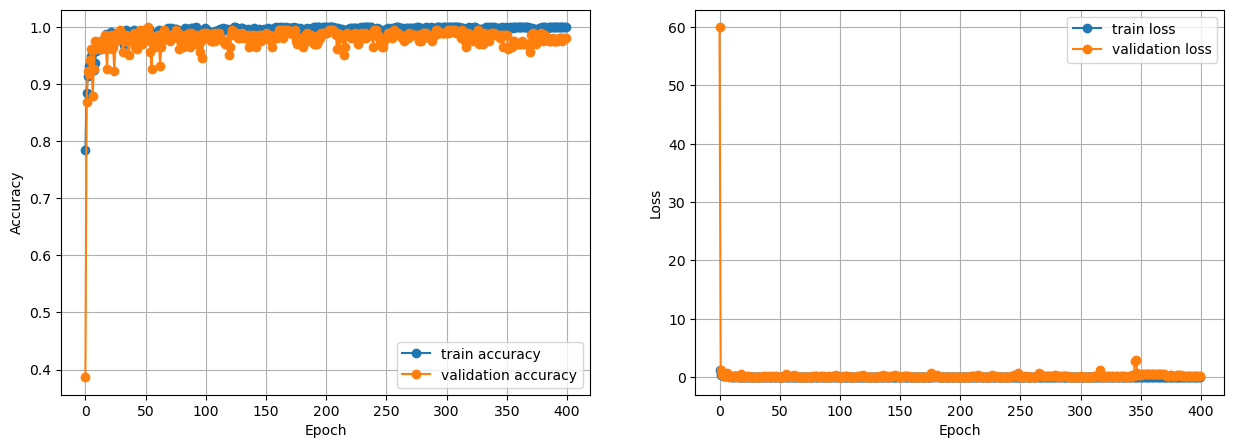

In [ ]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(h.history['accuracy'], 'o-', label='train accuracy')
plt.plot(h.history['val_accuracy'], 'o-', label = 'validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend(loc='lower right')

plt.subplot(1,2,2)
plt.plot(h.history['loss'], 'o-', label='train loss')
plt.plot(h.history['val_loss'], 'o-', label='validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend(loc='upper right')

plt.show()

In [ ]:
test_loss, test_acc = model.evaluate(X_test_norm, Y_test)
print('\nTest Accuracy:', test_acc)
print('\nTest Loss:', test_loss)

7/7 [==============================] - 0s 59ms/step - loss: 0.4001 - accuracy: 0.9714

Test Accuracy: 0.9714285731315613

Test Loss: 0.40007835626602173


In [ ]:
tf.keras.models.save_model(model, './resources/alexnet_model.h5', overwrite=True, include_optimizer=True, save_format=None , signatures=None, options=None)

**Discussion:**

This project aims to create a robust mask detection system utilizing the AlexNet architecture for image classification. The entire workflow involves dataset preparation, model training, and integration into a real-time webcam application. Here, we delve into the methodology, model training process, system performance, and the overall significance of the project.

**Dataset Preparation:**

The foundation of the project lies in a carefully curated dataset that encompasses diverse scenarios of mask-wearing behaviors.Dataset name is Face mask detector(mask ,not mask, incorrect mask) collected from Kaggle. The dataset is divided into three classes—Mask, No Mask, and Improper Mask—enabling the model to distinguish between different states of mask compliance. There are in total 2079 images. Each image undergoes preprocessing, including mean subtraction and resizing, ensuring uniformity in the input data.

**Model Architecture and Training:**

The chosen architecture, AlexNet, is a deep convolutional neural network known for its success in image classification tasks. The model consists of multiple convolutional and fully connected layers, utilizing rectified linear units (ReLU) for activation and incorporating batch normalization for improved convergence during training.

The training process involves optimizing the model using the Adam optimizer and sparse categorical cross-entropy as the loss function. The dataset is split into training, validation, and test sets to enable supervised learning. The model is trained over 400 epochs on the training set, with periodic evaluation on the validation set to monitor its generalization performance.

**Real-time Mask Detection Application:**

The trained model is seamlessly integrated into a real-time webcam application, enabling live monitoring of individuals' mask-wearing behaviors. The application employs the OpenCV library to capture frames from the webcam, and a pre-trained Haar Cascade classifier identifies faces within each frame. Extracted face regions undergo preprocessing before being fed into the AlexNet model for inference. The model's predictions are then used to classify individuals into the three defined categories—Mask, No Mask, and Improper Mask.

**System Performance:**

The accuracy of the model is a critical metric for evaluating its effectiveness. The model achieves a remarkable accuracy of approximately 97.14% on the test set, highlighting its ability to generalize well to unseen data. The training history, visualized through accuracy and loss curves, demonstrates the model's convergence and generalization capabilities over the training epochs.

**Project Overview:**

This project provides a comprehensive solution to the pressing need for automated mask detection in various public settings. By leveraging the power of deep learning and the well-established AlexNet architecture, the system demonstrates robustness and accuracy in classifying individuals based on their mask-wearing behavior. The real-time application extends the model's utility to practical scenarios, offering a valuable tool for enforcing safety measures and contributing to public health initiatives.

In summary, the project successfully combines state-of-the-art deep learning techniques with real-world applications, showcasing the potential of artificial intelligence in addressing contemporary challenges. The developed mask detection system serves as an exemplar of the intersection between technology and public health, providing a scalable solution for monitoring and promoting mask compliance in diverse environments.





